In [131]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 585 kB/s 


In [132]:
import torch as t
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from einops.layers.torch import Rearrange

import pandas as pd
import matplotlib.pyplot as plt

from typing import Callable
from tqdm.notebook import tqdm_notebook

In [53]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])

trainset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
# testset = datasets.MNIST(root="./data", train=False, transform=transform)
# testloader = DataLoader(testset, batch_size=64)

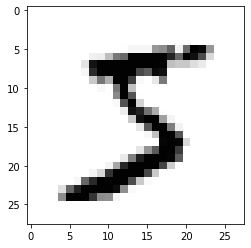

In [54]:
img = trainset[0][0]
plt.imshow(transforms.ToPILImage()(img), cmap='Greys', interpolation="nearest")

In [148]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims=5):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dims),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(),
            nn.Linear(128, 32 * 7 * 7),
            nn.ReLU(),
            Rearrange('b (c h w) -> b c h w', c=32, h=7, w=7),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),
        )

    def forward(self, x: t.Tensor) -> t.Tensor:
        x_compressed = self.encoder(x)
        x_reconstructed = self.decoder(x_compressed)
        return x_reconstructed

In [149]:
device = 'cuda:0' if t.cuda.is_available() else 'cpu'
device

'cuda:0'

In [150]:
def train_autoencoder(
    model,
    optimizer,
    trainloader: DataLoader,
    epochs: int,
    loss_fn: Callable,
    device: str = device,
) -> list:
    '''
    Defines a ConvNet using our previous code, and trains it on the data in trainloader.
    '''
    model.train()
    loss_list = []

    for epoch in tqdm_notebook(range(epochs)):
        inner_bar = tqdm_notebook(trainloader, leave=False)
        for x, _ in inner_bar:
            # Get batch
            x = x.to(device)

            # Zero grad
            optimizer.zero_grad()

            # Generate output
            x_prime = model(x)

            # Calculate loss
            loss = loss_fn(x_prime, x)

            # Backprop and step
            loss.backward()
            optimizer.step()

            # Metrics
            loss_list.append(loss.item())
            inner_bar.set_description(f'loss={loss.item() :.4f}')

    return loss_list

In [151]:
model = Autoencoder().to(device).train()
opt = t.optim.Adam(model.parameters())

In [152]:
loss_list = train_autoencoder(model, opt, trainloader, 10, nn.MSELoss())

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

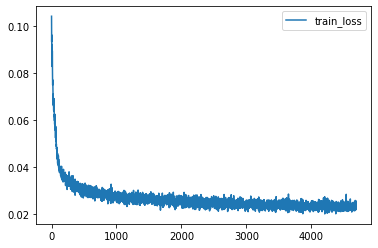

In [153]:
df = pd.DataFrame()
df['train_loss'] = loss_list
df.plot()

In [154]:
# Get samples of each digit eg. imgs[0] has tensor for digit 0
imgs = []
for i in range(10):
    loc_i = (trainset.targets == i).nonzero()[0][0].item()
    imgs.append(trainset[loc_i][0])

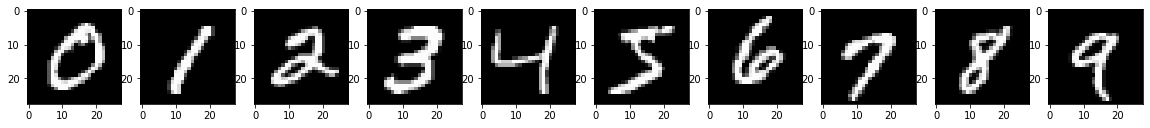

In [155]:
# Plot original images
fig = plt.figure(figsize=(20, 10))

for i in range(10):
    fig.add_subplot(1, 10, i+1)  
    plt.imshow(transforms.ToPILImage()(imgs[i]), cmap='gray')

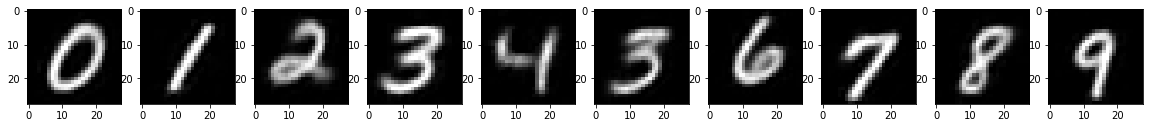

In [156]:
# Plot reconstructed images
fig = plt.figure(figsize=(20, 10))
model.eval()

for i in range(10):
    with t.inference_mode():
        rec = model(imgs[i].view(1, 1, 28, 28).to(device)).view(1, 28, 28)
    fig.add_subplot(1, 10, i+1)  
    plt.imshow(transforms.ToPILImage()(rec.clip(0, 1)), cmap='gray')

In [190]:
# Widget to explore latent space representation -> reconstruction
import ipywidgets as widgets

@widgets.interact(
    x0=(-5, 5, 0.1),
    x1=(-5, 5, 0.1),
    x2=(-5, 5, 0.1),
    x3=(-5, 5, 0.1),
    x4=(-5, 5, 0.1)
)
def update(x0=0, x1=0, x2=0, x3=0, x4=0):
    """Remove old lines from plot and plot new one"""
    latent_space = [x0, x1, x2, x3, x4]
    z = t.tensor(latent_space).to(device).view(1, 5)
    reconstruction = model.decoder(z).view(1, 28, 28)
    plt.imshow(transforms.ToPILImage()(reconstruction.clip(0, 1)), cmap='gray')

interactive(children=(FloatSlider(value=0.0, description='x0', max=5.0, min=-5.0), FloatSlider(value=0.0, desc…